#Python Chess Engine Train

**libraries**

---

In [ ]:
import glob                                     
import os                                       #  provides functions for interacting with the operating system.
import tensorflow as tf                         #  training and inference of deep neural networks.
import pandas as pd                             #  data analysis and manipulation
import numpy as np                              #  to  handle arrays and matrices
from sklearn.utils import shuffle               #  Shuffle arrays or sparse matrices

**connect to google drive**

---

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')                   # connect to drive

Mounted at /content/gdrive


**data**

---

import the chess games dataset from github

In [ ]:
!git clone https://github.com/DeotaleChinmay2001/chess-games-data.git           # clone github

Cloning into 'chess-games-data'...
remote: Enumerating objects: 1187, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 1187 (delta 160), reused 170 (delta 160), pack-reused 1017
Receiving objects: 100% (1187/1187), 9.13 MiB | 11.13 MiB/s, done.
Resolving deltas: 100% (1139/1139), done.
Checking out files: 100% (1133/1133), done.


In [ ]:
path_fischer = '/content/chess-games-data/CSV_FISCHER'                          #  path to dataset(on github)
path_morphy = '/content/chess-games-data/CSV_MORPHY'
path_capablanca = '/content/chess-games-data/CSV_CAPABLANCA'
# print(os.listdir())
files_fischer = glob.glob(path_fischer + "/*.csv")                              #  Getting all CSV files from a directory
#files_morphy = glob.glob(path_morphy + "/*.csv")
#files_capablanca = glob.glob(path_capablanca + "/*.csv")

# print(os.listdir(path_fischer))     
li = []                                                                         

for filename in files_fischer:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

train = pd.concat(li, axis=0, ignore_index=True)                                #  Concat all CSV file from the location

In [ ]:
train = shuffle(train)                                                          #  SUffle

In [ ]:
train.shape                                                                     #  dataframe dimensions

(830376, 193)

In [ ]:
train.head()

,a1,b1,c1,d1,e1,f1,g1,h1,a2,b2,...,to_h7,to_a8,to_b8,to_c8,to_d8,to_e8,to_f8,to_g8,to_h8,good_move
696659,None,K,None,R,None,None,None,R,N,P,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
827949,R,N,B,Q,K,None,None,R,P,P,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
674108,R,r,None,None,None,None,None,None,P,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
622374,None,None,None,R,K,None,None,R,P,b,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
239332,None,None,None,R,None,None,K,None,P,P,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


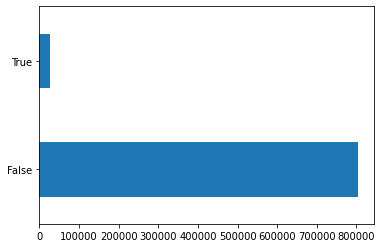

In [ ]:
train['good_move'].value_counts().plot(kind='barh')                           # Dataset Distribution

**features**

---

In [ ]:
features = list(train.iloc[:, 0:192].columns)                                   #  features except the output

In [ ]:
X = train[features]                                                             #  feature vector
y = train['good_move']                                                          #  Target Variable

In [ ]:
'''
      Directly takken from Tensorflow documentation : https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier
'''
categorical_columns = list(X.iloc[:, 0:63].columns)                             #  Categorical coloums/ Current State of Board
numerical_columns = list(X.iloc[:, 64:192].columns)                             #  Numerical colums containing showing From To movement of a piece
feature_columns = []

for feature_name in categorical_columns:
  vocabulary = X[feature_name].unique()                                         #  Numpy array of unique values in that column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))       #   feature column which takes as input some string and outputs a one-hot vector.


for feature_name in numerical_columns:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,dtype = tf.float32))

**input function**

---

In [ ]:
def make_input_fn(data_df, label_df, num_epochs = 10, shuffle = True, batch_size = 32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))          # Slice the list
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)                                # batch the dataset for the epoch of 10
    return ds
  return input_function                                                         #  return a function which is given to the estimator for training

**split data into batches**

---

In [ ]:
def split_into_batches(df, batch_size=100000):
  nb_rows = len(df.index)
  intervals = []
  
  for i in range(0, nb_rows + 1, batch_size):                                    # to get number of batches which will be formed
    intervals.append(i)
  
  if(intervals[-1] != nb_rows):                                                  # if last elements are not same                                                     
    intervals.append(nb_rows)                                                    # append last element
  
  batches_X = []                                                                 # list to store feature-array of batches
  batches_y = []                                                                 # list to store Target-array of batches
  
  for i in range(0, len(intervals) - 1):                                                        
    batches_X.append(train.iloc[intervals[i]:intervals[i + 1], :][features])     # create batches of features
    batches_y.append(train.iloc[intervals[i]:intervals[i + 1], :]['good_move'])  # create batches of corresponding Target variable

  return batches_X, batches_y                                                    # return batches

In [ ]:
batches_X, batches_y = split_into_batches(train)                                 # creates batches by calling function

**model**

---

In [ ]:
'''
                  Create Model Instance
'''
linear_est = tf.estimator.LinearClassifier(feature_columns = feature_columns, model_dir='/content/gdrive/MyDrive/chess-engine/estimator')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/MyDrive/chess-engine/estimator', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


**train model**

---

In [ ]:
input_functions = []
for df_X, df_y in zip(batches_X, batches_y):                                    # Generate input functions for corresponding batches
  input_functions.append(make_input_fn(df_X, df_y))

In [ ]:
len(input_functions)

9

In [ ]:
'''
train the model on all the input functions of all batches
Directly takken from Tensorflow documentation : https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier
'''
i = 1                                                                           
for input_function in input_functions:
  print('<======================================== NEW BATCH ========================================>')
  print('Batch: ' + str(i))
  i = i + 1
  linear_est.train(input_function)                                                                            # tran the model for respective batch
  

# save the model
serving_input_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(
  tf.feature_column.make_parse_example_spec(feature_columns))

estimator_base_path = '/content/gdrive/MyDrive/chess-engine/estimator'
estimator_path = linear_est.export_saved_model(estimator_base_path, serving_input_fn)

<======================================== NEW BATCH ========================================>
Batch: 1
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


Streaming output truncated to the last 5000 lines.
INFO:tensorflow:global_step/sec: 78.7853
INFO:tensorflow:loss = 0.37400496, step = 1491600 (1.265 sec)
INFO:tensorflow:global_step/sec: 79.513
INFO:tensorflow:loss = 0.031425223, step = 1491700 (1.262 sec)
INFO:tensorflow:global_step/sec: 83.1111
INFO:tensorflow:loss = 0.12661092, step = 1491800 (1.205 sec)
INFO:tensorflow:global_step/sec: 80.3442
INFO:tensorflow:loss = 0.13843167, step = 1491900 (1.241 sec)
INFO:tensorflow:global_step/sec: 81.4546
INFO:tensorflow:loss = 0.14197564, step = 1492000 (1.229 sec)
INFO:tensorflow:global_step/sec: 79.5991
INFO:tensorflow:loss = 0.2683902, step = 1492100 (1.255 sec)
INFO:tensorflow:global_step/sec: 80.0107
INFO:tensorflow:loss = 0.13673997, step = 1492200 (1.248 sec)
INFO:tensorflow:global_step/sec: 81.3179
INFO:tensorflow:loss = 0.023485348, step = 1492300 (1.232 sec)
INFO:tensorflow:global_step/sec: 80.0658
INFO:tensorflow:loss = 0.151791, step = 1492400 (1.247 sec)
INFO:tensorflow:global_s

In [ ]:
result = linear_est.evaluate(input_function)

# clear_output()
print(result)

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-05-26T09:02:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /content/gdrive/MyDrive/chess-engine/estimator/model.ckpt-1735000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 104.08638s
INFO:tensorflow:Finished evaluation at 2022-05-26-09:04:19
INFO:tensorflow:Saving dict for global step 1735000: accuracy = 0.96777064, accuracy_baseline = 0.96777064, auc = 0.6991651, auc_precision_recall = 0.07157386, average_loss = 0.13447104, global_step = 1735000, label/mean = 0.03222939, loss = 0.13455145, precision = 0.0, prediction/mean = 0.034433108, recall = 0.0
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1735000: /content/gdrive/MyDrive/chess-engine/estimator/model.ckpt-1735000
{'accuracy': 0.96777064, 'accuracy_baseline': 0.96777064, 'auc': 0.6991651, 'auc_precision_recall': 0.07157386, 'ave

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /content/gdrive/MyDrive/chess-engine/estimator/model.ckpt-1735000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


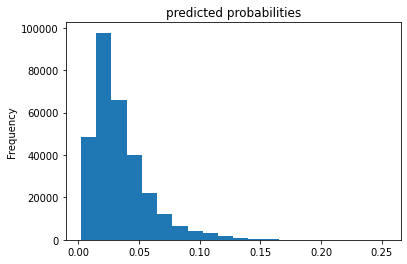

In [ ]:
'''
            Prbability Distribution based on what model predicted 
'''
pred_dicts = list(linear_est.predict(input_function))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [ ]:
files_capablanca = glob.glob(path_capablanca + "/*.csv")

li1 = []                                                                         

for filename in files_capablanca:
    df = pd.read_csv(filename, index_col=None, header=0)
    li1.append(df)

train = pd.concat(li1, axis=0, ignore_index=True)                                #  Concat all CSV file from the location

features = list(train.iloc[:, 0:192].columns)                                   #  features except the output

X = train[features]                                                             #  feature vector
y = train['good_move']  

categorical_columns = list(X.iloc[:, 0:63].columns)                             #  Categorical coloums/ Current State of Board
numerical_columns = list(X.iloc[:, 64:192].columns)                             #  Numerical colums containing showing From To movement of a piece
feature_columns = []

for feature_name in categorical_columns:
  vocabulary = X[feature_name].unique()                                         #  Numpy array of unique values in that column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))       #   feature column which takes as input some string and outputs a one-hot vector.


for feature_name in numerical_columns:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,dtype = tf.float32))


batches_X, batches_y = split_into_batches(train)

input_functions = []
for df_X, df_y in zip(batches_X, batches_y):
  input_functions.append(make_input_fn(df_X, df_y))

len(input_functions)
result = linear_est.evaluate(input_function)

# clear_output()
print(result)

# pred_dicts = list(linear_est.predict(input_function))
# probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

# probs.plot(kind='hist', bins=20, title='predicted probabilities')


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-05-26T09:15:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /content/gdrive/MyDrive/chess-engine/estimator/model.ckpt-1735000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 105.11515s
INFO:tensorflow:Finished evaluation at 2022-05-26-09:17:09
INFO:tensorflow:Saving dict for global step 1735000: accuracy = 0.96777064, accuracy_baseline = 0.96777064, auc = 0.6991651, auc_precision_recall = 0.07157386, average_loss = 0.13447084, global_step = 1735000, label/mean = 0.03222939, loss = 0.13447994, precision = 0.0, prediction/mean = 0.03443306, recall = 0.0
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1735000: /content/gdrive/MyDrive/chess-engine/estimator/model.ckpt-1735000
{'accuracy': 0.96777064, 'accuracy_baseline': 0.96777064, 'auc': 0.6991651, 'auc_precision_recall': 0.07157386, 'aver

In [ ]:
y_pred = linear_est.predict(input_functions)

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_pred, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)

ValueError: ignored